# Guided Project - Answering Business Questions using SQL

This project is part of the Data Analyst in Python from Dataquest.<br>

On this project the main goal is to explore the writing and formating of complex queries. 

Let's verify which .db files do we have in the project file:

In [11]:
!ls *.db

chinook.db


Now, time to import the tools we're going to need: 

In [12]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

db = 'chinook.db'

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Now it's time to use queries to answer some question and make decisions!
<br>
We have a list with with 4 artists from 4 different genres:

- Artist Name (genre): Regal(Hip-Hop), Red Tone(Punk), Meteor and the Girls(Pop), Slim Jim Bites (Blues).

<br>
We need to choose 3 artists to advertise on the US. For this, we will write a query to find out which genres sell the most tracks in the USA, and then create a visualisation of that data using pandas.

In [13]:
albums_to_purchase = '''
WITH tracks_usa AS
    (
    SELECT
        il.*
    FROM invoice_line il
    INNER JOIN track t ON il.track_id = t.track_id
    INNER JOIN invoice i ON il.invoice_id = i.invoice_id
    WHERE i.billing_country = "USA"
    )
    
SELECT 
    g.name genre,
    COUNT(tu.invoice_line_id) tracks_sold,
    CAST(COUNT(tu.invoice_line_id) AS FLOAT) / (
                                      SELECT COUNT (*) FROM tracks_usa
                                      ) percentage
FROM tracks_usa tu
INNER JOIN track t ON tu.track_id = t.track_id
INNER JOIN genre g ON t.genre_id = g.genre_id
GROUP BY 1 
ORDER BY 3 DESC 
LIMIT 10
'''
run_query(albums_to_purchase)

,genre,tracks_sold,percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


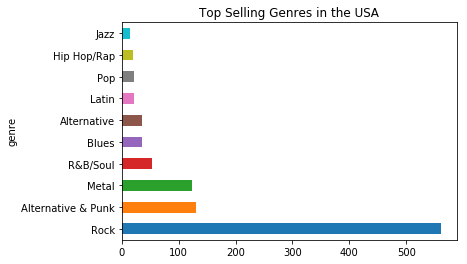

In [14]:
genre_sales_us = run_query(albums_to_purchase)

genre_sales_us.set_index('genre', inplace=True, drop=True)

genre_sales_us['tracks_sold'].plot.barh(title="Top Selling Genres in the USA")


Based on the sales of tracks accross differents genres in the USA, we should purchase the following albums:
- Red Tone (punk);
- Slim Jim Bites (Blues);
- Meteor and the Girls (Pop).

It's important to remember that this is the best scenario for the options that were given, but those 3 genres combined represent just 17% of the US market, so the company should look for albums on the Rock genre, which represents 53% of the market alone.

# Now let's analyse the employees performance:

First by sales amount versus the hiring date:

In [15]:
emp_sales_performance = '''
WITH cust_rep_sales AS
    (
    SELECT
        i.customer_id,
        c.support_rep_id,
        SUM(i.total) total
    FROM invoice i
    INNER JOIN customer c ON i.customer_id = c.customer_id
    GROUP BY 1,2
    )
SELECT
    e.first_name || ' ' || e.last_name name,
    e.hire_date,
    SUM(crs.total) total
FROM cust_rep_sales crs
INNER JOIN employee e ON crs.support_rep_id = e.employee_id
GROUP BY 1
'''
run_query(emp_sales_performance)

,name,hire_date,total
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


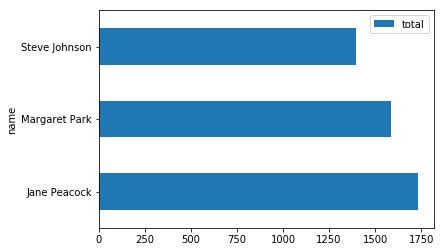

In [16]:
emp_perfo = run_query(emp_sales_performance)
emp_perfo.set_index('name', inplace=True, drop=True)
emp_perfo.plot.barh()

Although Jane Peacock has more sales in numbers, it is impressive that Steve Jhonson, having way less months to be counted on the sample data, has a similiar performance comparing with the two others employees.

# Let's have a look in the sales by country:

In [25]:
sales_by_country = '''
WITH country_or_other AS
    (
    SELECT
        CASE
            WHEN (
                  SELECT count(*)
                  FROM customer
                  WHERE country = c.country
                  ) = 1 THEN "Other"
            ELSE c.country
        END AS country,
        c.customer_id,
        il.*
    FROM invoice_line il
    INNER JOIN invoice i ON il.invoice_id = i.invoice_id
    INNER JOIN customer c ON i.customer_id = c.customer_id
    )
    
SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        COUNT(DISTINCT customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / COUNT(DISTINCT customer_id) customer_lifetime_value,
        SUM(unit_price) / COUNT(DISTINCT  invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''
run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


# We're going to create several different plots to help us to visualize the data we have:

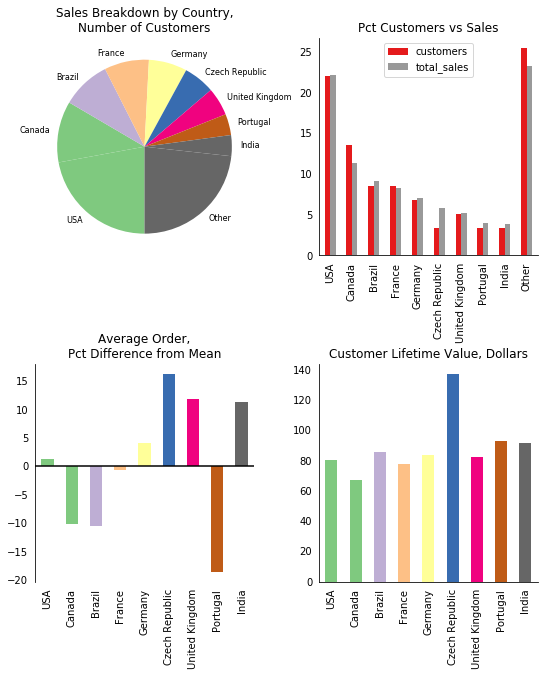

In [37]:
country_metrics = run_query(sales_by_country)

country_metrics.set_index('country', drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(9,10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5,wspace=.3)

# top left
sales_breakdown = country_metrics['total_sales'].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top=False, right=False, left=False, bottom=False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# bottom left
avg_order = country_metrics['average_order'].copy()
avg_order.index.name=''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop('Other', inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title='Average Order,\nPct Difference from Mean'
)
ax3.tick_params(top=False,bottom=False,left=False,right=False)
ax3.axhline(0,color='k')
ax3.spines['top'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['right'].set_visible(False)

# bottom right

ltv = country_metrics['customer_lifetime_value'].copy()
ltv.index.name = ''
ltv.drop('Other',inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title='Customer Lifetime Value, Dollars'
)
ax4.tick_params(top=False,bottom=False,left=False,right=False)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.show()

Based on the data, there may be opportunity in the following countries:

- Czech Republic;
- United Kingdom;
- India.

<br>
It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

In [44]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668



Album purchases account for 18.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.